# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
print('shape of rows and columns of general population',azdias.shape)
print('shapr of rows and columns of feature',feat_info.shape)

shape of rows and columns of general population (891221, 85)
shapr of rows and columns of feature (85, 4)


In [6]:
print(azdias.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [8]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [9]:
# Checking if any nulls present
azdias.isnull().any()

AGER_TYP                 False
ALTERSKATEGORIE_GROB     False
ANREDE_KZ                False
CJT_GESAMTTYP             True
FINANZ_MINIMALIST        False
FINANZ_SPARER            False
FINANZ_VORSORGER         False
FINANZ_ANLEGER           False
FINANZ_UNAUFFAELLIGER    False
FINANZ_HAUSBAUER         False
FINANZTYP                False
GEBURTSJAHR              False
GFK_URLAUBERTYP           True
GREEN_AVANTGARDE         False
HEALTH_TYP               False
LP_LEBENSPHASE_FEIN       True
LP_LEBENSPHASE_GROB       True
LP_FAMILIE_FEIN           True
LP_FAMILIE_GROB           True
LP_STATUS_FEIN            True
LP_STATUS_GROB            True
NATIONALITAET_KZ         False
PRAEGENDE_JUGENDJAHRE    False
RETOURTYP_BK_S            True
SEMIO_SOZ                False
SEMIO_FAM                False
SEMIO_REL                False
SEMIO_MAT                False
SEMIO_VERT               False
SEMIO_LUST               False
                         ...  
OST_WEST_KZ               True
WOHNLAGE

In [10]:
# Nulls present in each column
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
# total number of nulls
azdias.isnull().sum().sum()

4896838

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
(azdias.columns.values==feat_info.attribute).all()

True

In [13]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [14]:
col_names = azdias.columns
col_names

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [15]:
import time

_Please help with below code block that I have put under observation.Why is it taking long time and giving less number of NA's.This will be for my understanding_

In [16]:
# Under Observation #
#feat_info.set_index('attribute', inplace=True)
# start=time.time()
# for col_name in col_names:
#     azdias[col_name] = azdias[col_name].map(lambda x: np.nan if str(x) in feat_info.loc[col_name].missing_or_unknown else x)
    

# #Save the result into a new df as this step takes a long time to run    
# azdias.to_csv('azdias_parsed.csv', sep=';', index = False)

In [17]:
for index in feat_info.index:
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

In [18]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [19]:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [20]:
azdias.isnull().sum().sum()

8373929

In [21]:
#azdias.to_csv('azdias_processed_new.csv',sep=';',index=False)

In [22]:
azdias=pd.read_csv('azdias_processed_new.csv',sep=';')

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [23]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col=azdias.isnull().sum()
missing_col

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [24]:
missing_col.sum()

8373929

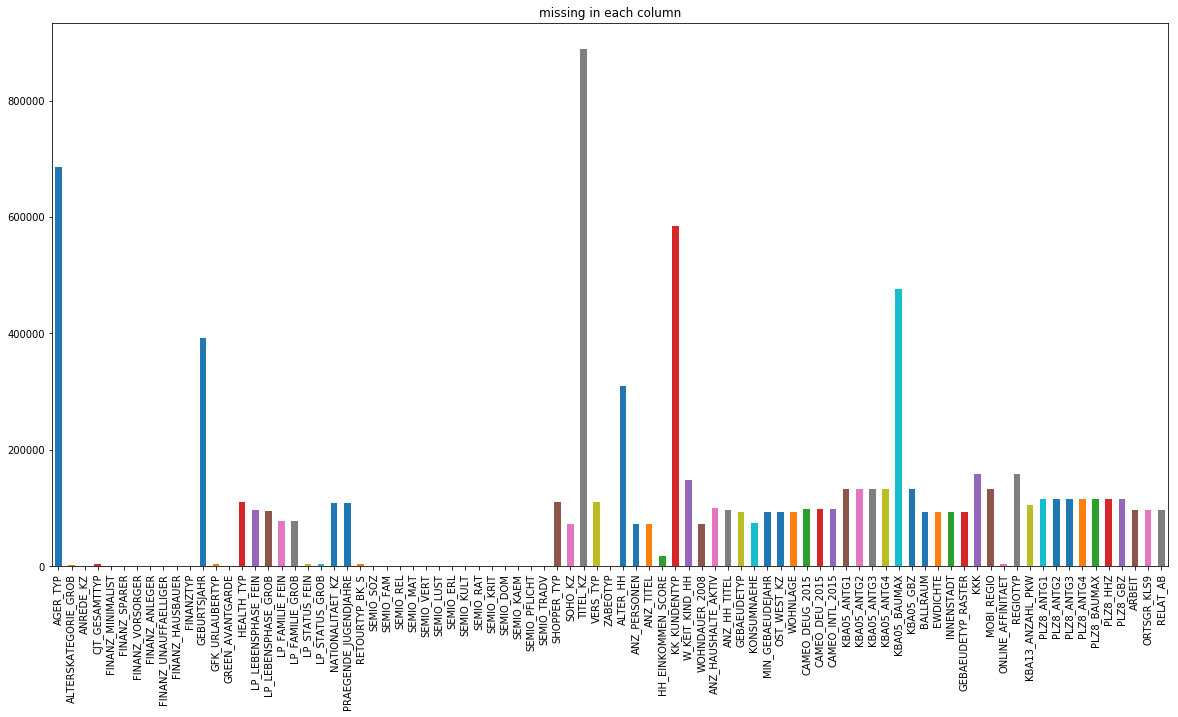

In [25]:
#missing in each column
missing_col.plot.bar(figsize=(20,10),title="missing in each column")
plt.show()


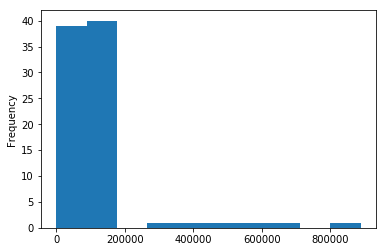

In [26]:
# Investigate patterns in the amount of missing data in each column.
missing_col.plot.hist()


In [27]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Remove columns with more than 20%  or 200000 observation
greater_than_20=missing_col[missing_col/ azdias.shape[0] *100>20]
drop_cols=greater_than_20.index.values
drop_cols

array(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'], dtype=object)

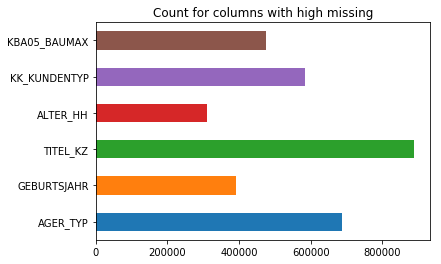

In [28]:
missing_col[drop_cols].plot.barh(title="Count for columns with high missing")

In [29]:
azdias.drop(drop_cols,axis=1,inplace=True)

In [30]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

I have begun with preprocessing the dataset and converting missing value codes to NaN's. Next we observed the proportion of missing values in each column.By looking at the hist plot and bar plot we observe that some columns are missing greater than 200000 values.Out of the original 85 columns, only 6 columns have greater than 200000 values missing. Columns 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP','KBA05_BAUMAX' have more than 200000 missing.
There are two ways to deal with it.

1. We can either impute these missing data with mean median or mode for the columns
2. We can drop these columns

Droppig columns having much higher proportion of missing data is necessary since imputing them is not feasible.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [31]:
# How much data is missing in each row of the dataset?
missing_rows=azdias.isnull().sum(axis=1)
missing_rows

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [32]:
missing_rows.sum()

5035304

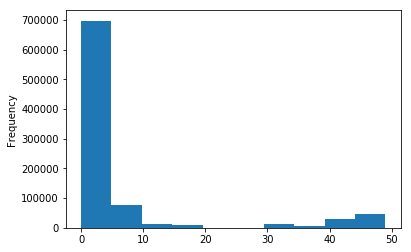

In [33]:
# plt.hist(missing_rows);
missing_rows.plot.hist()

In [34]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# consider  azdias.shape[1] observations per row
perc=missing_rows/azdias.shape[1]*100
perc

0         54.430380
1          0.000000
2          0.000000
3          8.860759
4          0.000000
5          0.000000
6          0.000000
7          0.000000
8          0.000000
9          0.000000
10         0.000000
11        59.493671
12         7.594937
13        10.126582
14        59.493671
15        10.126582
16         7.594937
17        59.493671
18         3.797468
19         0.000000
20        12.658228
21         0.000000
22         0.000000
23        10.126582
24        59.493671
25         6.329114
26        24.050633
27         0.000000
28         0.000000
29         2.531646
            ...    
891191     0.000000
891192     0.000000
891193     0.000000
891194     0.000000
891195     0.000000
891196     0.000000
891197     0.000000
891198     0.000000
891199     0.000000
891200     0.000000
891201     0.000000
891202     0.000000
891203    17.721519
891204     0.000000
891205     0.000000
891206     0.000000
891207     0.000000
891208     3.797468
891209     0.000000


In [35]:
less_missing=azdias.loc[perc<20,:]
less_missing.shape

(792287, 79)

In [36]:
more_missing=azdias.loc[perc>20,:]
more_missing.shape

(98934, 79)

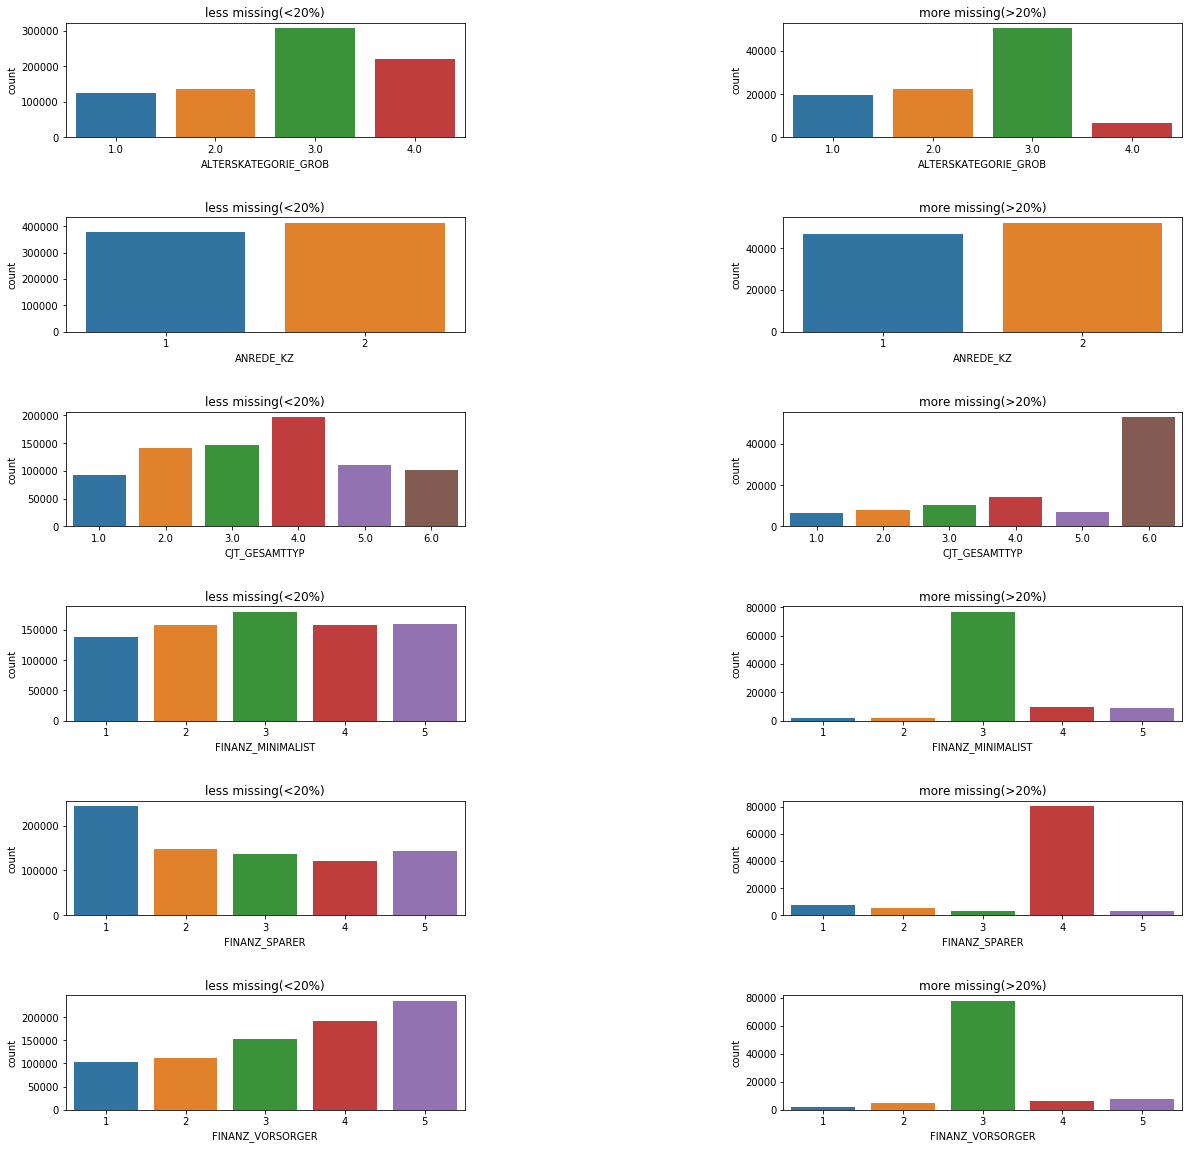

In [37]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def count_plot(columns):
    length=len(columns)
    
    fig,axes=plt.subplots(nrows=length,ncols=2,figsize=(20,20))
    plt.subplots_adjust(hspace=0.7,wspace=0.8)
    for i in range(length):
        sns.countplot(less_missing[columns[i]],ax=axes[i,0]).set_title('less missing(<20%)')
        sns.countplot(more_missing[columns[i]],ax=axes[i,1]).set_title('more missing(>20%)')

list_of_col=['ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER']
count_plot(list_of_col)

In [38]:
less_missing.isnull().sum(axis=1).sum() # much less than earlier of 5035304

910769

#### Discussion 1.1.3: Assess Missing Data in Each Row

**Continue with less than 20% missing**

If we observe the histogram for the missing row we see that most rows have less than 20 values missing.I have set the threshold for missing number of observation in a row to 20%. After observing the plots for the 2 distribuions, one with less than 20% values missing and one with more than 20% missing it can be seen that there are some columns with similar distributions across the rows. Since the clustering algorithm requires no missing observation we proceed with the less than 20% missing dataset which we can easily impute later. If on the other hand we keep all the missing observation the model my be incorrect since we are imputing many observations which may not be the real values

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [39]:
print(feat_info.type.value_counts(sort=True,ascending=True))

interval        1
numeric         7
mixed           7
categorical    21
ordinal        49
Name: type, dtype: int64


In [40]:
# How many features are there of each data type?
feat_info.groupby(by='type').count().sort_values(by='attribute',ascending=True).attribute


type
interval        1
mixed           7
numeric         7
categorical    21
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [41]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# cat_columns=[]
# for i in range(len(feat_info.type)):
#     if feat_info.type[i]=='categorical':
#         #print(feat_info.attribute[i])
#         cat_columns.append(feat_info.attribute[i])
# print(cat_columns)
# print(drop_cols)
# cat_columns_new=[n for n in cat_columns if n not in drop_cols]
# print(cat_columns_new)

In [42]:
categorical=feat_info[feat_info['type']=='categorical']['attribute']
categorical=[x for x in categorical if x not in drop_cols]
print(categorical)

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [43]:
print(less_missing[categorical].nunique())

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64


In [44]:
binary=[x for x in categorical if azdias[x].nunique()==2]
print(binary)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [45]:
multilevel=[x for x in categorical if azdias[x].nunique()>2]
print(multilevel)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [46]:
for i in multilevel:
    print(i,less_missing[i].unique())

CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP [1 6 5 2 4 3]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
LP_FAMILIE_FEIN [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ [ 1.  3.  2. nan]
SHOPPER_TYP [ 3.  2.  1.  0. nan]
ZABEOTYP [5 3 4 1 6 2]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
CAMEO_DEUG_2015 [ 8.  4.  2.  6.  1.  9.  5.  7.  3. nan]
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


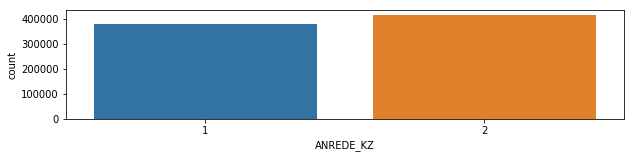

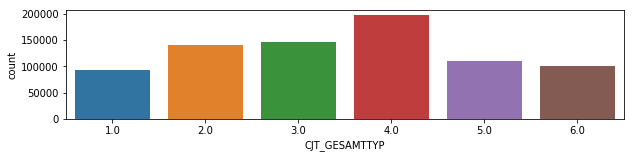

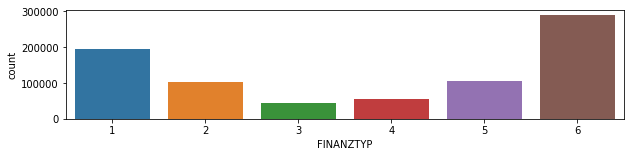

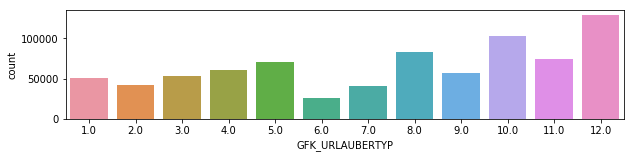

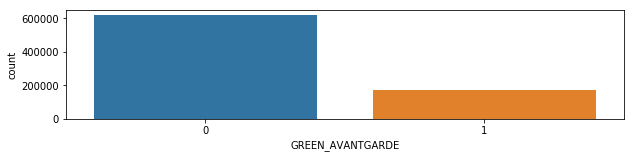

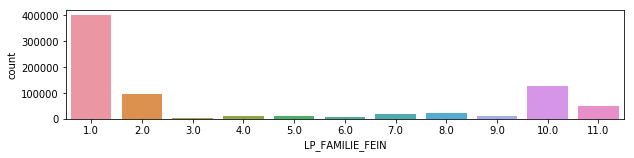

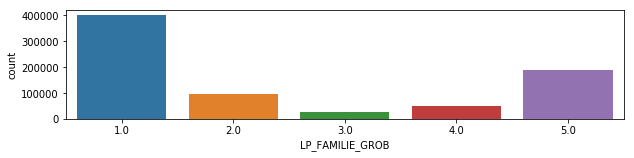

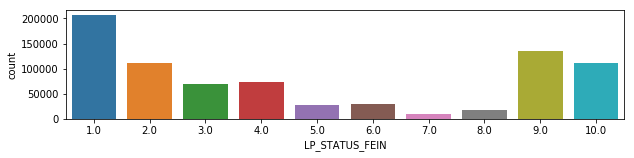

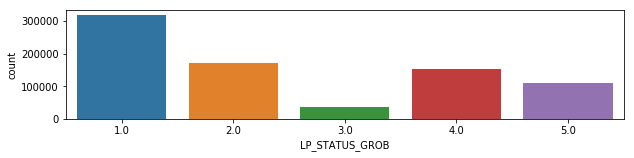

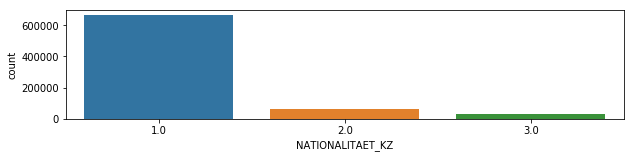

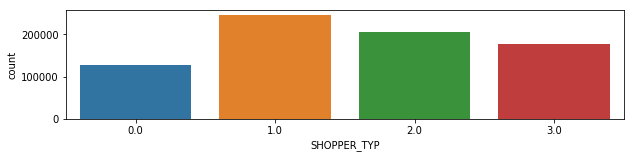

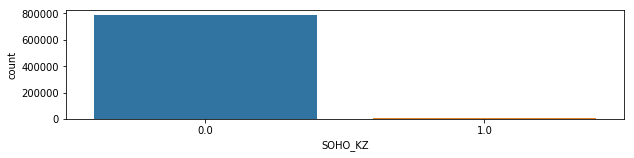

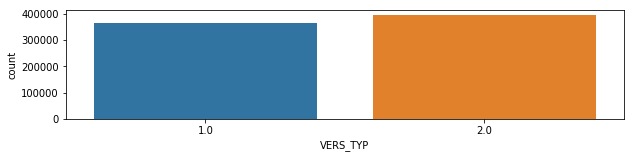

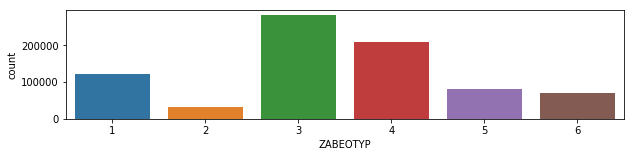

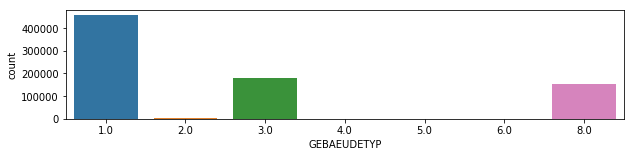

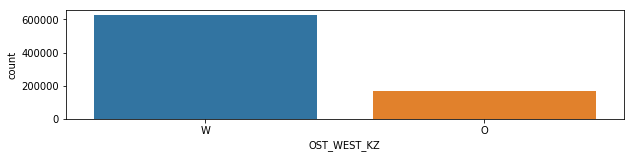

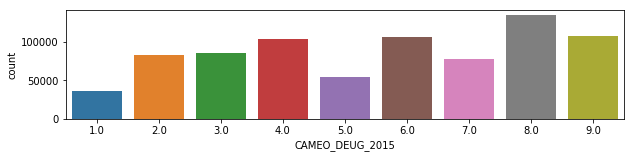

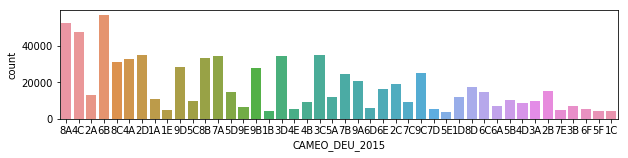

In [47]:
# plotting
# please uncomment
for cat in categorical:
    plt.figure(figsize=(10,2))
    sns.countplot(less_missing[cat])
    plt.show()

GFK_URLAUBERTYP drop vacation
LP_FAMILIE_FIEN- finer scale
LP_STATUS_FEIN- status finer scale
CAMEO_DEU_2015-  finer scale



In [48]:

# # Drop CAMEO DEU_2015 which has 44 features which is too granular for a single column.
# multilevel.remove('CAMEO_DEU_2015')
# azdias_lowmiss.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [49]:
drop_columns_large_cat=[x for x in multilevel if less_missing[x].nunique()>=10]
print('dropped columns with >=10 categories\n',drop_columns_large_cat)

dropped columns with >=10 categories
 ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']


In [50]:
less_missing.drop(drop_columns_large_cat,axis=1,inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [51]:
#drop_columns_large_cat=['CAMEO_DEU_2015','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN']

In [52]:
multilevel=[x for x in multilevel if x not in drop_columns_large_cat] # >greater than 10 categories
multilevel

['CJT_GESAMTTYP',
 'FINANZTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [53]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [54]:
# Re-encode categorical variable(s) to be kept in the analysis.
for i in binary:
    print(i,less_missing[i].unique())

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [1. 0.]
VERS_TYP [ 2.  1. nan]
OST_WEST_KZ ['W' 'O']


In [55]:
less_missing['OST_WEST_KZ']=less_missing['OST_WEST_KZ'].map({'W':0,'O':1}) # changing W->0 and O ->1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
less_missing.OST_WEST_KZ.unique()

array([0, 1], dtype=int64)

In [57]:
for i in multilevel:
    print(i,less_missing[i].unique(),less_missing[i].nunique())

CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan] 6
FINANZTYP [1 6 5 2 4 3] 6
LP_FAMILIE_GROB [ 3.  1. nan  5.  2.  4.] 5
LP_STATUS_GROB [ 1.  2.  4.  5.  3. nan] 5
NATIONALITAET_KZ [ 1.  3.  2. nan] 3
SHOPPER_TYP [ 3.  2.  1.  0. nan] 4
ZABEOTYP [5 3 4 1 6 2] 6
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.] 7
CAMEO_DEUG_2015 [ 8.  4.  2.  6.  1.  9.  5.  7.  3. nan] 9


In [58]:
less_missing[multilevel]=less_missing[multilevel].astype('float64')

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [59]:
less_missing[multilevel].dtypes

CJT_GESAMTTYP       float64
FINANZTYP           float64
LP_FAMILIE_GROB     float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
ZABEOTYP            float64
GEBAEUDETYP         float64
CAMEO_DEUG_2015     float64
dtype: object

In [60]:
less_missing[multilevel].head()

,CJT_GESAMTTYP,FINANZTYP,LP_FAMILIE_GROB,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015
1,5.0,1.0,3.0,1.0,1.0,3.0,5.0,8.0,8.0
2,3.0,1.0,1.0,2.0,1.0,2.0,5.0,1.0,4.0
3,2.0,6.0,NaN,4.0,1.0,1.0,3.0,1.0,2.0
4,5.0,5.0,5.0,2.0,1.0,2.0,4.0,1.0,6.0
5,2.0,2.0,1.0,2.0,1.0,0.0,4.0,1.0,8.0


In [61]:
encoded=pd.get_dummies(data=less_missing,columns=multilevel)
# encoded=less_missing.join(temp)
encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0


In [62]:
# encoded.drop(multilevel,axis=1,inplace=True)

In [63]:
encoded.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ',
       'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA

#### Discussion 1.2.1: Re-Encode Categorical Features

Since the algorithms deal with numeric values we need to convert the categorical values to numeric values. This is done by one hot encoding where for each unique observation we make a separate column with 1 only where the value is present and 0 otherwise.
Here since some of the columns were dropped in earlier steps,I have been removed them from list of categorical variables.
Among categorical variables with two level 'OST_WEST_KZ' needs to be remaped inorder to have numeric values
After observing the variables I have decided to drop variables with greater than 10 unique values since they are on finer scale and contain too many categories.
GFK_URLAUBERTYP -drop vacation 
LP_FAMILIE_FIEN- finer scale 
LP_STATUS_FEIN- status finer scale 
CAMEO_DEU_2015- finer scale ~44 categories have been dropped and their non finer version should suffice

I proceed forward with the remaining categorical variables and perform one hot encoding on them

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [64]:
feat_info[feat_info.type=='mixed']['attribute'] #KBA05_BAUMAX has been dropped

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [65]:
mixed=feat_info[feat_info.type=='mixed']['attribute']
mixed=[x for x in mixed if x in encoded.columns]# keeping only columns in encoded
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [66]:
encoded.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    181525
8.0     140681
10.0     85276
5.0      84400
3.0      53615
15.0     42078
11.0     35448
9.0      33515
6.0      25629
12.0     24340
1.0      20550
4.0      20431
2.0       7470
13.0      5714
7.0       4000
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [67]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
avantgarde=[]

for x in encoded.PRAEGENDE_JUGENDJAHRE:
    if x in [2,4,6,7,9,11,13,15]:
        avantgarde.append(1) # denotes avantgarde
    elif x in [1,3,5,8,10,12,14]:
        avantgarde.append(0) # denotes mainstream
    else:
        avantgarde.append(np.nan)
encoded['Movement']=avantgarde

In [68]:
decade_map={1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90,-1:np.nan,0:np.nan}
decade=encoded.PRAEGENDE_JUGENDJAHRE.map(decade_map)
encoded['Decade']=decade

In [69]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
encoded.CAMEO_INTL_2015.value_counts() # still present in dataset


51.0    133492
41.0     92080
24.0     90699
14.0     62565
43.0     56495
54.0     45287
25.0     39413
22.0     32931
13.0     26162
45.0     26038
23.0     26028
55.0     23866
52.0     20508
31.0     18661
34.0     18445
15.0     16913
44.0     14776
12.0     13136
35.0     10316
32.0     10304
33.0      9856
Name: CAMEO_INTL_2015, dtype: int64

In [70]:
life_stage=[]
Wealth=[]
for x in encoded.CAMEO_INTL_2015:
    if x in [-1,'XX',np.nan]:
        life_stage.append(np.nan)
        Wealth.append(np.nan)
    else:
        Wealth.append((x)//10)
        life_stage.append(float(x)%10)
    

In [71]:
encoded['Wealth']=Wealth
encoded['Life_Stage']=life_stage

In [72]:
encoded.Wealth.value_counts()

5.0    223153
4.0    189389
2.0    189071
1.0    118776
3.0     67582
Name: Wealth, dtype: int64

In [73]:
encoded.Life_Stage.value_counts()

1.0    244233
4.0    231772
3.0    118541
5.0    116546
2.0     76879
Name: Life_Stage, dtype: int64

In [74]:
encoded.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_4.0', 'CAMEO_DEUG_2015_5.0', 'CAMEO_DEUG_2015_6.0',
       'CAMEO_DEUG_2015_7.0', 'CAMEO_DEUG_2015_8.0', 'CAMEO_DEUG_2015_9.0',
       'Movement', 'Decade', 'Wealth', 'Life_Stage'],
      dtype='object', length=121)

In [75]:
drop_colums_mixed=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN']# drop these

In [76]:
encoded.drop(drop_colums_mixed,axis=1,inplace=True)

In [77]:
encoded.shape

(792287, 118)

In [78]:
mixed=[x for x in mixed if x not in drop_colums_mixed]
mixed # apply one hot encoding on these

['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

In [79]:
final_encode=pd.get_dummies(data=encoded,columns=mixed)
#final_encode=encoded.join(temp)
final_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,1,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,1,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,1,0,1,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,1,0,0,0,0


In [80]:
#final_encode.drop(mixed,axis=1,inplace=True)

In [81]:
final_encode.shape

(792287, 140)

In [82]:
final_encode.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEI

#### Discussion 1.2.2: Engineer Mixed-Type Features

Mixed dataypes contain more than one variables mixed together which we need to separte into 2 seperate variables."PRAEGENDE_JUGENDJAHRE" has been seperated into avantgarde and Decade and 'CAMEO_INTL_2015' into Wealth and life stage. 'LP_LEBENSPHASE_FEIN' has been dropped as it is on finer scale and 'LP_LEBENSPHASE_GROB' should suffice.

After this i applied one hot encoding on the mixed variables



After investigating drop 3 columns 'LP_LEBENSPHASE_FEIN'  finer scale,
'PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'-> transformed


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [83]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
miss_list=final_encode.isnull().sum()
# miss_perc=miss_list/final_encode.shape[0]*100
# miss_perc[miss_perc>20]
miss_list

ALTERSKATEGORIE_GROB         2740
ANREDE_KZ                       0
FINANZ_MINIMALIST               0
FINANZ_SPARER                   0
FINANZ_VORSORGER                0
FINANZ_ANLEGER                  0
FINANZ_UNAUFFAELLIGER           0
FINANZ_HAUSBAUER                0
GREEN_AVANTGARDE                0
HEALTH_TYP                  35855
RETOURTYP_BK_S               4368
SEMIO_SOZ                       0
SEMIO_FAM                       0
SEMIO_REL                       0
SEMIO_MAT                       0
SEMIO_VERT                      0
SEMIO_LUST                      0
SEMIO_ERL                       0
SEMIO_KULT                      0
SEMIO_RAT                       0
SEMIO_KRIT                      0
SEMIO_DOM                       0
SEMIO_KAEM                      0
SEMIO_PFLICHT                   0
SEMIO_TRADV                     0
SOHO_KZ                         0
VERS_TYP                    35855
ANZ_PERSONEN                    0
ANZ_TITEL                       0
HH_EINKOMMEN_S

In [84]:
for col in final_encode.columns:
    print(col,final_encode[col].unique())

ALTERSKATEGORIE_GROB [ 1.  3.  4.  2. nan]
ANREDE_KZ [2 1]
FINANZ_MINIMALIST [1 4 3 2 5]
FINANZ_SPARER [5 4 2 3 1]
FINANZ_VORSORGER [2 1 5 4 3]
FINANZ_ANLEGER [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER [4 3 1 2 5]
FINANZ_HAUSBAUER [5 2 3 4 1]
GREEN_AVANTGARDE [0 1]
HEALTH_TYP [ 3.  2.  1. nan]
RETOURTYP_BK_S [ 1.  3.  2.  5.  4. nan]
SEMIO_SOZ [5 4 6 2 7 3 1]
SEMIO_FAM [4 1 5 7 2 6 3]
SEMIO_REL [4 3 2 7 5 1 6]
SEMIO_MAT [3 1 2 4 7 5 6]
SEMIO_VERT [1 4 7 2 6 5 3]
SEMIO_LUST [2 4 6 7 3 1 5]
SEMIO_ERL [2 6 7 4 5 1 3]
SEMIO_KULT [3 4 6 5 7 1 2]
SEMIO_RAT [6 4 3 2 7 5 1]
SEMIO_KRIT [4 7 3 1 5 6 2]
SEMIO_DOM [7 4 2 1 5 6 3]
SEMIO_KAEM [4 7 5 2 3 6 1]
SEMIO_PFLICHT [7 3 4 5 1 6 2]
SEMIO_TRADV [6 3 4 2 7 5 1]
SOHO_KZ [1. 0.]
VERS_TYP [ 2.  1. nan]
ANZ_PERSONEN [ 2.  1.  0.  4.  3.  5.  6.  7.  8. 12.  9. 21. 10. 13. 11. 14. 45. 20.
 31. 37. 16. 22. 15. 23. 18. 35. 17. 40. 38.]
ANZ_TITEL [0. 1. 2. 4. 3.]
HH_EINKOMMEN_SCORE [6. 4. 1. 5. 3. 2.]
W_KEIT_KIND_HH [ 3. nan  2.  6.  5.  4.  1.]
WOHNDAUER_2008 [

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [85]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info=pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index in feat_info.index:
        feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
        for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
            try:
                feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
            except:
                continue
        df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

    
    # remove selected columns and rows, ...
    # columns
    missing_col=df.isnull().sum()
    print('missing per columns\n',missing_col)
    print()
    print('total missing\n',missing_col.sum())
    print()
    #plot barh
    missing_col.plot.bar(figsize=(20,10))  
    plt.show()
    # plot hist
    missing_col.plot.hist()
    plt.show()

    # remove greater than 20% missing column
#     greater_than_20=missing_col[missing_col/ df.shape[0] *100>20]
#     drop_cols=greater_than_20.index.values
    drop_cols=['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    print('dropping these columns\n',drop_cols)
    df.drop(drop_cols,axis=1,inplace=True)
    
    
    # rows
    ######## missing in rows ########

    missing_rows=df.isnull().sum(axis=1)
    print('missing per row\n',missing_rows)
    print()
    print('total missing\n',missing_rows.sum())
    print()
    #plot hist
    missing_rows.plot.hist()
    plt.show()
    # percentage
    perc=missing_rows/df.shape[1]*100
    # less missing
    less_missing=df.loc[perc<20,:]
    print('shape of missing less than 20%',less_missing.shape)
    # more missing
    more_missing=df.loc[perc>20,:]
    print('shape of missing more than 20%',more_missing.shape)
    

    # select, re-encode, and engineer column values.
    
    ############ encoding ###########
    # number of types
    print(feat_info.type.value_counts(sort=True,ascending=True))
    # all categorical
    categorical=feat_info[feat_info['type']=='categorical']['attribute']
    categorical=[x for x in categorical if x not in drop_cols]
    print('list of categorical variables\n',categorical)
    print('no of unique elements in each variable\n',less_missing[categorical].nunique())

    binary=[x for x in categorical if less_missing[x].nunique()==2]
    print('variables with 2 elements\n',binary)

    multilevel=[x for x in categorical if less_missing[x].nunique()>2]
    print('variable with multiple levels\n',multilevel)

    drop_columns_large_cat=[x for x in multilevel if less_missing[x].nunique()>=10]
    print('dropped columns with >=10 categories\n',drop_columns_large_cat)

    less_missing.drop(drop_columns_large_cat,axis=1,inplace=True)
    
    multilevel=[x for x in multilevel if x not in drop_columns_large_cat]
    print('variables left after dropping:\n',multilevel)

    # reencode binary variables
    print('Variables binary,Unique Values')
    for i in binary:
        print(i,less_missing[i].unique())
    less_missing['OST_WEST_KZ']=less_missing['OST_WEST_KZ'].map({'W':0,'O':1})
    print('Checking after encoded\n',less_missing.OST_WEST_KZ.unique())

    # reencode mulilevel variables
    print('Varibles multilevel,Unique Values')
    for i in multilevel:
        print(i,less_missing[i].nunique())
    
#     less_missing['CAMEO_DEUG_2015']=less_missing['CAMEO_DEUG_2015'].astype('float64')
    less_missing[multilevel]=less_missing[multilevel].astype('float64')
    print(less_missing[multilevel].dtypes)
    encoded=pd.get_dummies(data=less_missing,columns=multilevel)



    ############### mixed data types #######

    mixed=feat_info[feat_info.type=='mixed']['attribute']
    mixed=[x for x in mixed if x in encoded.columns]# keeping only columns in encoded
    print('Variables with mixed values\n',mixed)

    # engineer 2 variables
    # "PRAEGENDE_JUGENDJAHRE"
    avantgarde=[]

    for x in encoded.PRAEGENDE_JUGENDJAHRE:
        if x in [2,4,6,7,9,11,13,15]:
            avantgarde.append(1) # denotes avantgarde
        elif x in [1,3,5,8,10,12,14]:
            avantgarde.append(0) # denotes mainstream
        else:
            avantgarde.append(np.nan)
    encoded['Movement']=avantgarde

    decade_map={1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90,-1:np.nan,0:np.nan}
    decade=encoded.PRAEGENDE_JUGENDJAHRE.map(decade_map)
    encoded['Decade']=decade

    # "CAMEO_INTL_2015"

    life_stage=[]
    Wealth=[]
    for x in encoded.CAMEO_INTL_2015:
        if x in [-1,'XX',np.nan]:
            life_stage.append(np.nan)
            Wealth.append(np.nan)
        else:
            Wealth.append(float(x)//10)
            life_stage.append(float(x)%10)


    encoded['Wealth']=Wealth
    encoded['Life_Stage']=life_stage

    # drop mixed

    drop_colums_mixed=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN']
    print('Droppig mixed columns\n',drop_colums_mixed)
    encoded.drop(drop_colums_mixed,axis=1,inplace=True)
    mixed=[x for x in mixed if x not in drop_colums_mixed]

    final_encode_df=pd.get_dummies(data=encoded,columns=mixed)
    
    # Return the cleaned dataframe.
    # for missing columns
    columns=[x for x in final_encode.columns if x not in final_encode_df.columns]
    print('*'*50)
    print(columns)
    
    return final_encode_df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [86]:
final_encode.isnull().sum().sum()

673849

In [87]:
import pdb

In [146]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer # getting deprecated
#from sklearn.impute import SimpleImputer
impute=Imputer()
#pdb.set_trace()
impute=impute.fit(final_encode)
imputed_dataset=impute.transform(final_encode)

imputed_dataset=pd.DataFrame(imputed_dataset,columns=final_encode.columns)

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [147]:
imputed_dataset.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [90]:
imputed_dataset.isnull().sum().sum()

0

In [148]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler=scaler.fit(imputed_dataset)
dataset=scaler.transform(imputed_dataset)

In [149]:
dataset=pd.DataFrame(dataset,columns=final_encode.columns)
dataset.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,-1.766262,0.958103,-1.492816,1.538634,-1.042098,1.466664,0.966060,1.335003,-0.531050,1.083295,...,-0.676423,2.202425,-0.32073,-0.520236,-0.146913,0.766152,-0.312251,-0.261542,-0.277559,-0.374196
1,0.200742,0.958103,-1.492816,0.865411,-1.768435,-0.570410,0.250485,1.335003,1.883063,1.083295,...,-0.676423,-0.454045,-0.32073,-0.520236,-0.146913,0.766152,-0.312251,-0.261542,-0.277559,-0.374196
2,1.184244,0.958103,0.684789,-0.481036,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.272064,...,-0.676423,-0.454045,-0.32073,1.922204,-0.146913,0.766152,-0.312251,-0.261542,-0.277559,-0.374196
3,0.200742,-1.043729,0.684789,0.192187,0.410577,-1.249434,0.250485,-0.799862,-0.531050,1.083295,...,1.478364,-0.454045,-0.32073,-0.520236,-0.146913,-1.305223,3.202548,-0.261542,-0.277559,-0.374196
4,-1.766262,0.958103,-0.041079,-1.154259,1.136914,-0.570410,-0.465090,1.335003,-0.531050,1.083295,...,-0.676423,-0.454045,-0.32073,1.922204,-0.146913,0.766152,-0.312251,-0.261542,-0.277559,-0.374196


### Discussion 2.1: Apply Feature Scaling
In order to proceed with pca and clustering I have imputed the data with means.
I have observed that the variables are on different scales and this can vastly affect the clustering since clustering is based on euclidean distances and not applying feature scaling can change the meaning of the clusters.So I have applied standardization with zero mean and 1 std deviation

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [93]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
def do_pca(n_components,data):
    pca=PCA(n_components,random_state=10)
    X=pca.fit_transform(data)
    
    return pca,X

In [94]:
pca=PCA()
dataset_pca=pca.fit_transform(dataset)
dataset.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,-1.766262,0.958103,-1.492816,1.538634,-1.042098,1.466664,0.966060,1.335003,-0.531050,1.083295,...,-0.676423,2.202425,-0.32073,-0.520236,-0.146913,0.766152,-0.312251,-0.261542,-0.277559,-0.374196
1,0.200742,0.958103,-1.492816,0.865411,-1.768435,-0.570410,0.250485,1.335003,1.883063,1.083295,...,-0.676423,-0.454045,-0.32073,-0.520236,-0.146913,0.766152,-0.312251,-0.261542,-0.277559,-0.374196
2,1.184244,0.958103,0.684789,-0.481036,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.272064,...,-0.676423,-0.454045,-0.32073,1.922204,-0.146913,0.766152,-0.312251,-0.261542,-0.277559,-0.374196
3,0.200742,-1.043729,0.684789,0.192187,0.410577,-1.249434,0.250485,-0.799862,-0.531050,1.083295,...,1.478364,-0.454045,-0.32073,-0.520236,-0.146913,-1.305223,3.202548,-0.261542,-0.277559,-0.374196
4,-1.766262,0.958103,-0.041079,-1.154259,1.136914,-0.570410,-0.465090,1.335003,-0.531050,1.083295,...,-0.676423,-0.454045,-0.32073,1.922204,-0.146913,0.766152,-0.312251,-0.261542,-0.277559,-0.374196


In [95]:
len(pca.explained_variance_ratio_)

140

In [96]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_of_components=pca.n_components_
    ind=np.arange(num_of_components)
    vals=pca.explained_variance_ratio_
    
    plt.figure(figsize=(25,10))
    ax=plt.subplot(111)
    cumvals=np.cumsum(vals)
    ax.bar(ind,vals)
    ax.plot(ind,cumvals)
    for i in range(num_of_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    plt.xlim(-5,150)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')



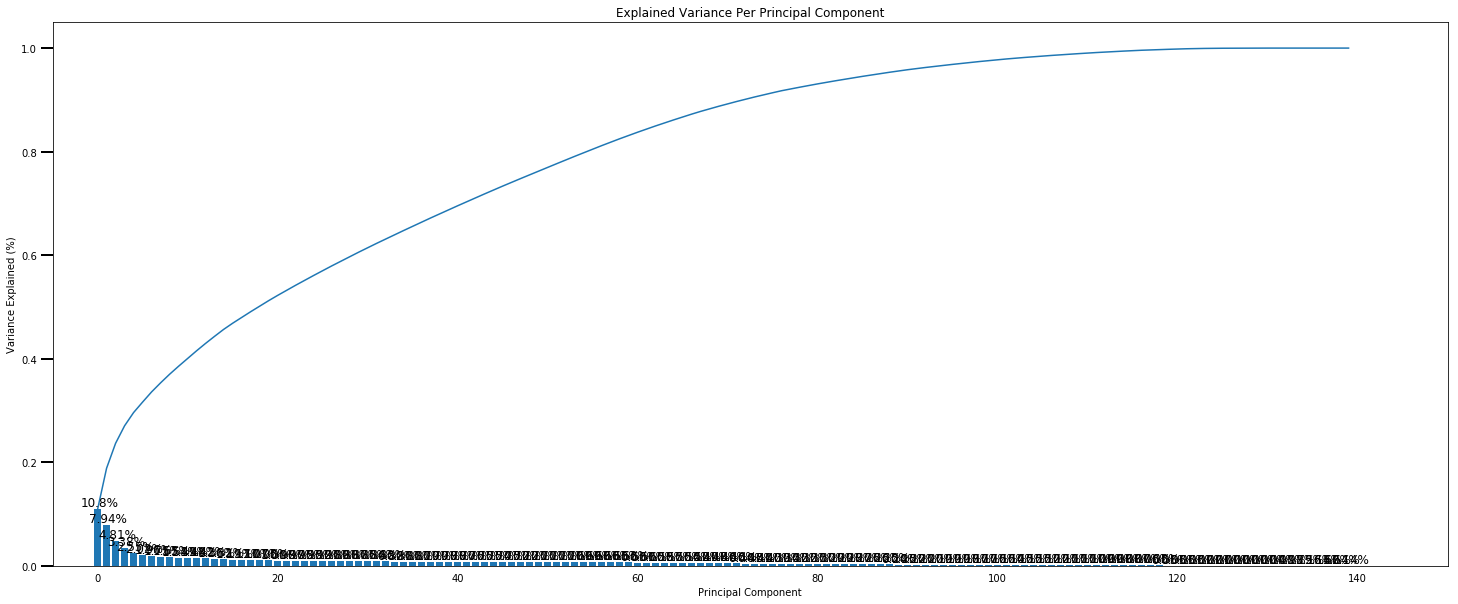

In [97]:
scree_plot(pca)

In [98]:
pca.explained_variance_ratio_[:70].sum() # explained variance by first 0 components

0.8875169582481431

In [99]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_new=PCA(n_components=70,random_state=10).fit(dataset)
X_pca=pca_new.transform(dataset)


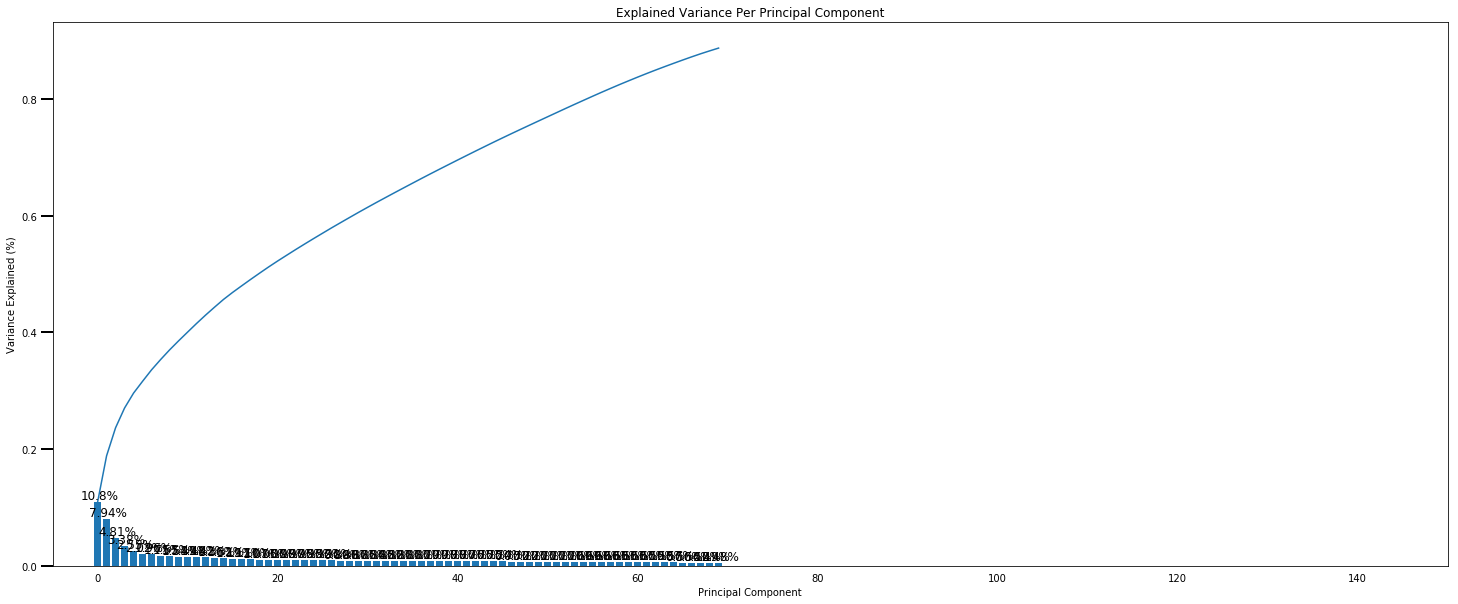

In [100]:
scree_plot(pca_new)

### Discussion 2.2: Perform Dimensionality Reduction

First i fitted PCA with all the variables in order to obtain the scree plot of explained variances. From the plot we can see that 70 principal components explain more than 80% variance. I reinstiated my pca model with 70 principal components

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [101]:
ind=['PC {}'.format(i) for i in range(1,len(pca_new.components_)+1)] 
variance_ratio=pd.DataFrame(pca_new.explained_variance_ratio_,columns=['Explained Variance Ratio'],index=ind)
variance_ratio

,Explained Variance Ratio
PC 1,0.108978
PC 2,0.079463
PC 3,0.048120
PC 4,0.033854
PC 5,0.025556
PC 6,0.020229
PC 7,0.019649
PC 8,0.017508
PC 9,0.016593
PC 10,0.015496


In [102]:
pca_new.components_.shape

(70, 140)

In [103]:
features_weights=pd.DataFrame(pca_new.components_,columns=dataset.columns,index=ind)
features_weights.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
PC 1,-0.084271,0.013332,-0.188406,0.113619,-0.083909,0.051396,0.051952,0.147004,-0.096684,0.024562,...,0.035996,0.071680,0.056847,-0.110331,-0.037293,-0.179937,0.041424,0.063665,0.083737,0.117514
PC 2,0.233334,0.045493,0.086115,-0.226649,0.221557,-0.198047,-0.216807,0.089014,-0.008667,-0.051497,...,0.020710,0.017614,0.008328,-0.040537,-0.026294,-0.062314,0.019136,0.025864,0.029966,0.036029
PC 3,0.026690,-0.350087,0.137221,-0.065583,0.057591,-0.155605,-0.058181,-0.058487,0.065093,-0.011213,...,0.009763,0.007072,0.017114,-0.033490,-0.014671,-0.046159,0.009220,0.009868,0.015338,0.040673
PC 4,-0.015776,0.068178,0.037693,-0.004692,-0.010924,-0.083785,0.056620,-0.065736,0.307983,-0.008373,...,0.074330,-0.001084,-0.013088,-0.197658,-0.037217,-0.080029,0.035350,0.000119,0.009119,0.078075
PC 5,0.046526,-0.030583,0.035372,-0.017107,0.023678,0.056864,-0.099979,-0.022839,-0.125747,0.001374,...,0.003356,0.033028,0.039343,0.025391,0.035331,-0.060253,-0.009648,0.057990,0.085494,-0.010237


In [104]:
result=pd.concat([variance_ratio,features_weights],axis=1)
result.head()

,Explained Variance Ratio,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
PC 1,0.108978,-0.084271,0.013332,-0.188406,0.113619,-0.083909,0.051396,0.051952,0.147004,-0.096684,...,0.035996,0.071680,0.056847,-0.110331,-0.037293,-0.179937,0.041424,0.063665,0.083737,0.117514
PC 2,0.079463,0.233334,0.045493,0.086115,-0.226649,0.221557,-0.198047,-0.216807,0.089014,-0.008667,...,0.020710,0.017614,0.008328,-0.040537,-0.026294,-0.062314,0.019136,0.025864,0.029966,0.036029
PC 3,0.048120,0.026690,-0.350087,0.137221,-0.065583,0.057591,-0.155605,-0.058181,-0.058487,0.065093,...,0.009763,0.007072,0.017114,-0.033490,-0.014671,-0.046159,0.009220,0.009868,0.015338,0.040673
PC 4,0.033854,-0.015776,0.068178,0.037693,-0.004692,-0.010924,-0.083785,0.056620,-0.065736,0.307983,...,0.074330,-0.001084,-0.013088,-0.197658,-0.037217,-0.080029,0.035350,0.000119,0.009119,0.078075
PC 5,0.025556,0.046526,-0.030583,0.035372,-0.017107,0.023678,0.056864,-0.099979,-0.022839,-0.125747,...,0.003356,0.033028,0.039343,0.025391,0.035331,-0.060253,-0.009648,0.057990,0.085494,-0.010237


In [105]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def show_weights(pc):
    ''' takes input principal component number and number of weights to be printed
    pc=int: principal component number from 1 to 70
    
    '''
    features_weights=pd.DataFrame(pca_new.components_,columns=dataset.columns)
    #print(features_weights.iloc[pc-1,:].sort_values(ascending=False))
    return (features_weights.iloc[pc-1,:].sort_values(ascending=False))

In [106]:
# first principal component   
first_component=show_weights(1)
print('first10')
print(first_component[:5])
print()
print('last10')
print(first_component[-5:])

first10
LP_STATUS_GROB_1.0    0.191767
PLZ8_ANTG3            0.189788
PLZ8_ANTG4            0.183869
Wealth                0.181013
HH_EINKOMMEN_SCORE    0.180201
Name: 0, dtype: float64

last10
KBA05_GBZ           -0.182259
FINANZ_MINIMALIST   -0.188406
PLZ8_ANTG1          -0.189753
KBA05_ANTG1         -0.191047
MOBI_REGIO          -0.204549
Name: 0, dtype: float64


In [107]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second_component=show_weights(2)
print('first10')
print(second_component[:5])
print()
print('last10')
print(second_component[-5:])

first10
ALTERSKATEGORIE_GROB    0.233334
FINANZ_VORSORGER        0.221557
ZABEOTYP_3.0            0.201986
SEMIO_ERL               0.184522
SEMIO_LUST              0.162826
Name: 1, dtype: float64

last10
SEMIO_TRADV             -0.209391
SEMIO_REL               -0.216269
FINANZ_UNAUFFAELLIGER   -0.216807
FINANZ_SPARER           -0.226649
Decade                  -0.238454
Name: 1, dtype: float64


In [108]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

third_component=show_weights(3)
print('first10\n')
print(third_component[:5])
print()
print('last10\n')
print(third_component[-5:])

first10

SEMIO_VERT           0.324205
SEMIO_FAM            0.259206
SEMIO_SOZ            0.257554
SEMIO_KULT           0.249380
FINANZ_MINIMALIST    0.137221
Name: 2, dtype: float64

last10

SEMIO_ERL    -0.202989
SEMIO_KRIT   -0.269514
SEMIO_DOM    -0.291533
SEMIO_KAEM   -0.321828
ANREDE_KZ    -0.350087
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

**Principal Component 1**

top5

LP_STATUS_GROB_1 Social Stattus: low income earners
PLZ8_ANTG3 Number of 6-10 family houses in the PLZ8 region
PLZ8_ANTG4 Number of 10+ family houses in the PLZ8 region
Wealth- wealth
HH_EINKOMMEN_SCORE- Estimated household net income

bottom5

KBA05_GBZ Number of buildings in the microcell
FINANZ_MINIMALIST Financial typology:low financial interest
PLZ8_ANTG1 Number of 1-2 family houses in the PLZ8 region
KBA05_ANTG1 Number of 1-2 family houses in the microcell
MOBI_REGIO  Movement patterns

The first principal component is pointing towards mixture  of income and density and financial intereset. It appears that there is a negative correlation between income and number of people in house and low income earners have low financial interest

**Principal component 2**

top5

ALTERSKATEGORIE_GROB Estimated age based on given name analysis
FINANZ_VORSORGER be prepared
ZABEOTYP  Energy consumption typology
SEMIO_ERL event-oriented
SEMIO_LUST sensual-minded

bottom 5

SEMIO_TRADV traditional minded
SEMIO_REL religious
FINANZ_UNAUFFAELLIGER  inconspicuous
FINANZ_SPARER money-saver
Decade- decade of the youth

The Second Principal Componet points towards a mixture of age and personality typology.As Decade goes down Estimated age goes up.If estimated age goes up the person os more financially prepared,even oriented and sensual and 


**Principal Component 3**

top5

SEMIO_VERT  dreamful
SEMIO_FAM family minded
SEMIO_SOZ socially minded
SEMIO_KULT  cultural minded
FINANZ_MINIMALIST

bottom 5

SEMIO_ERL  event oriented
SEMIO_KRIT   critical minded
SEMIO_DOM    dominant minded
SEMIO_KAEM   combative attitude
ANREDE_KZ   Gender

third principal cult is mostly based on mixture of Personality Topology and Gender

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [109]:
from sklearn.cluster import KMeans

In [110]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
def get_score(clusters,data):
    '''
        cluster:int, number of clusters
        data:dataset
    '''
    kmeans=KMeans(n_clusters=clusters)
    model=kmeans.fit(data)
    score=np.abs(model.score(data))
    
    return score
   

In [111]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
score=[]
centres=list(range(1,30))
for x in range(1,30):
    score.append(get_score(x,X_pca))



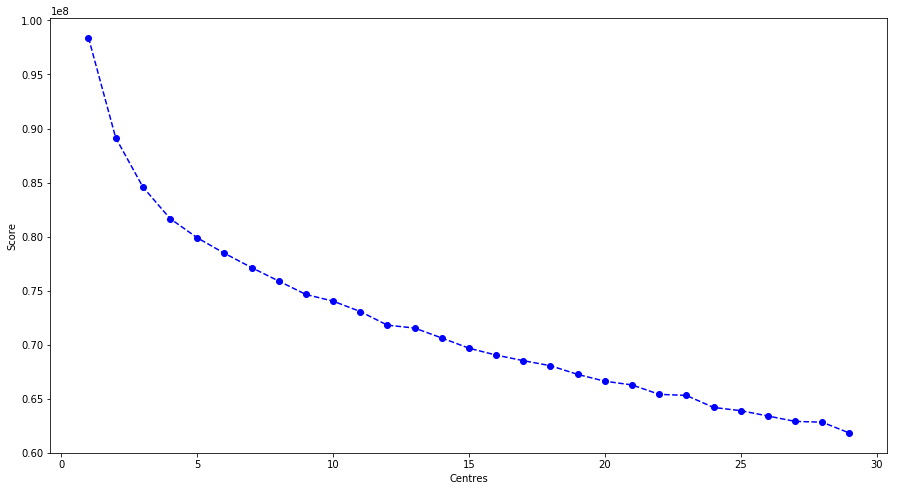

In [112]:
plt.figure(figsize=(15,8))
plt.plot(centres,score,linestyle='--',marker='o',color='blue')
plt.xlabel('Centres')
plt.ylabel('Score')
plt.show()


In [111]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_new=KMeans(n_clusters=15,random_state=10)
kmeans_new=kmeans_new.fit(X_pca)
kmeans_new

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [112]:
general_predictions=kmeans_new.predict(X_pca)
general_predictions

array([ 8,  9,  7, ...,  9,  0, 11])

### Discussion 3.1: Apply Clustering to General Population

In order to find the number of clusters , i use the elbow method and find the cluster number for which increase in clusters dosen't decrease the average distance from cluster centres by much.In the graph, there is no clear elbow and drop in distance is marginal after 15 clusters. So I decided to go ahead with 15 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [113]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [114]:
customers.shape

(191652, 85)

missing per columns
 AGER_TYP                  96738
ALTERSKATEGORIE_GROB        240
ANREDE_KZ                     0
CJT_GESAMTTYP              3213
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR               93024
GFK_URLAUBERTYP            3213
GREEN_AVANTGARDE              0
HEALTH_TYP                48990
LP_LEBENSPHASE_FEIN       51053
LP_LEBENSPHASE_GROB       50941
LP_FAMILIE_FEIN           50582
LP_FAMILIE_GROB           50582
LP_STATUS_FEIN             3213
LP_STATUS_GROB             3213
NATIONALITAET_KZ          48750
PRAEGENDE_JUGENDJAHRE     48487
RETOURTYP_BK_S             3213
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                   

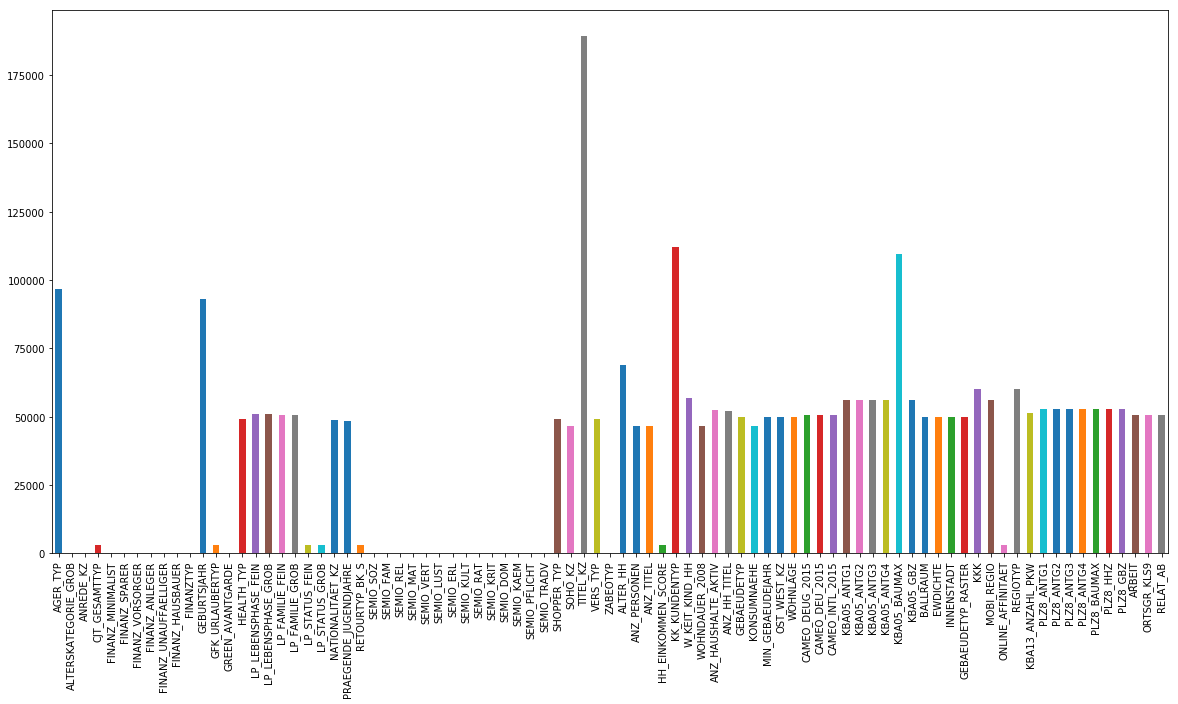

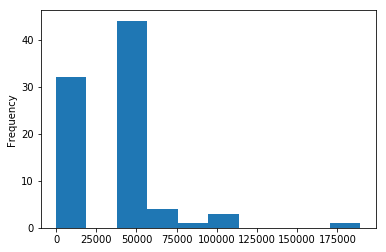

dropping these columns
 ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
missing per row
 0          0
1         45
2          0
3          7
4          0
5          0
6          0
7          0
8          2
9          0
10        34
11         0
12         0
13         6
14         0
15         0
16         0
17         0
18         0
19         0
20         6
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
191622     0
191623     0
191624     0
191625     0
191626     0
191627     0
191628     0
191629     0
191630     0
191631     5
191632     0
191633     0
191634     0
191635     0
191636     0
191637     0
191638     0
191639     8
191640     0
191641     0
191642     0
191643     0
191644     0
191645     0
191646     0
191647     0
191648    14
191649     0
191650     0
191651     0
Length: 191652, dtype: int64

total missing
 2443597



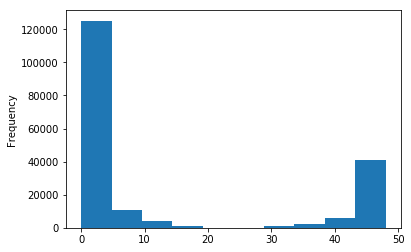

shape of missing less than 20% (140898, 79)
shape of missing more than 20% (50754, 79)
interval        1
numeric         7
mixed           7
categorical    21
ordinal        49
Name: type, dtype: int64
list of categorical variables
 ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
no of unique elements in each variable
 ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          6
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64
variab

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ANREDE_KZ [1 2]
GREEN_AVANTGARDE [1 0]
SOHO_KZ [0. 1.]
VERS_TYP [ 1.  2. nan]
OST_WEST_KZ ['W' 'O']
Checking after encoded
 [0 1]
Varibles multilevel,Unique Values
CJT_GESAMTTYP 6
FINANZTYP 6
LP_FAMILIE_GROB 5
LP_STATUS_GROB 5
NATIONALITAET_KZ 3
SHOPPER_TYP 4
ZABEOTYP 6
GEBAEUDETYP 6
CAMEO_DEUG_2015 9


D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


CJT_GESAMTTYP       float64
FINANZTYP           float64
LP_FAMILIE_GROB     float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
ZABEOTYP            float64
GEBAEUDETYP         float64
CAMEO_DEUG_2015     float64
dtype: object
Variables with mixed values
 ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
Droppig mixed columns
 ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN']
**************************************************
['GEBAEUDETYP_5.0']


In [115]:
customer_cleaned=clean_data(customers)

In [116]:
customer_cleaned.shape

(140898, 139)

In [117]:
[x for x in final_encode.columns if x not in customer_cleaned ]

['GEBAEUDETYP_5.0']

In [118]:
customer_cleaned['GEBAEUDETYP_5.0']=0

In [119]:
[x for x in final_encode.columns if x not in customer_cleaned ]

[]

In [120]:
customer_cleaned.shape

(140898, 140)

In [121]:
customer_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,GEBAEUDETYP_5.0
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,1,0,1,0,0,0,0,0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,1,0,0,0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,1,0,1,0,0,0,0,0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,1,0,0,0,0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,1,0,0,0,0,0


In [150]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# impute dataset
imputed_customers_dataset=impute.transform(customer_cleaned)

imputed_customers_dataset=pd.DataFrame(imputed_customers_dataset,columns= customer_cleaned.columns)
imputed_customers_dataset.head()
# imputed_customers_dataset

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,GEBAEUDETYP_5.0
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [151]:
# feature scaling
customer_dataset=scaler.transform(imputed_customers_dataset)
customer_dataset=pd.DataFrame(customer_dataset,columns=customer_cleaned.columns)
customer_dataset.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,GEBAEUDETYP_5.0
0,1.184244,-1.043729,1.410658,-1.154259,1.136914,-1.249434,-0.465090,-0.799862,1.883063,-1.627422,...,-0.676423,-0.454045,3.117886,-0.520236,6.806747,-1.305223,-0.312251,-0.261542,-0.277559,-0.374196
1,1.184244,0.958103,1.410658,-1.154259,1.136914,-1.249434,0.966060,0.623381,1.883063,-0.272064,...,-0.676423,-0.454045,-0.320730,-0.520236,-0.146913,-1.305223,3.202548,-0.261542,-0.277559,-0.374196
2,1.184244,-1.043729,1.410658,-1.154259,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.272064,...,-0.676423,-0.454045,3.117886,-0.520236,6.806747,-1.305223,-0.312251,-0.261542,-0.277559,-0.374196
3,0.200742,-1.043729,-0.041079,-1.154259,0.410577,0.787639,1.681635,-0.799862,-0.531050,1.083295,...,-0.676423,-0.454045,-0.320730,-0.520236,-0.146913,0.766152,-0.312251,-0.261542,-0.277559,-0.374196
4,0.200742,-1.043729,1.410658,-1.154259,1.136914,-1.249434,-0.465090,-0.088241,1.883063,1.083295,...,-0.676423,-0.454045,-0.320730,-0.520236,6.806747,-1.305223,-0.312251,-0.261542,-0.277559,-0.374196


In [152]:
#PCA
customers_pca=pca_new.transform(customer_dataset)
customers_pca

array([[-16.27930731,   2.34570528,  11.52676905, ...,   4.56794267,
         -7.57311205,  -4.33529125],
       [-12.46711016,   5.73629465,   6.96005576, ...,   6.92670696,
        -10.26730621,  -1.78316234],
       [-13.65475949,   0.79551705,   9.16315702, ...,   2.94642052,
         -5.1460658 ,  -3.25131616],
       ...,
       [-15.73922779,   2.92278836,  10.28435614, ...,   5.30861024,
         -6.91704004,  -2.91543358],
       [-17.13213136,   2.15866112,   8.36461008, ...,   8.2668567 ,
        -12.78339774,  -4.02843071],
       [-16.16790994,  -2.47922404,  10.538979  , ...,   4.23839292,
         -6.50760713,  -5.12515345]])

In [153]:
# Clustering

customer_predictions=kmeans_new.predict(customers_pca)
customer_predictions

array([1, 1, 1, ..., 1, 1, 6])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

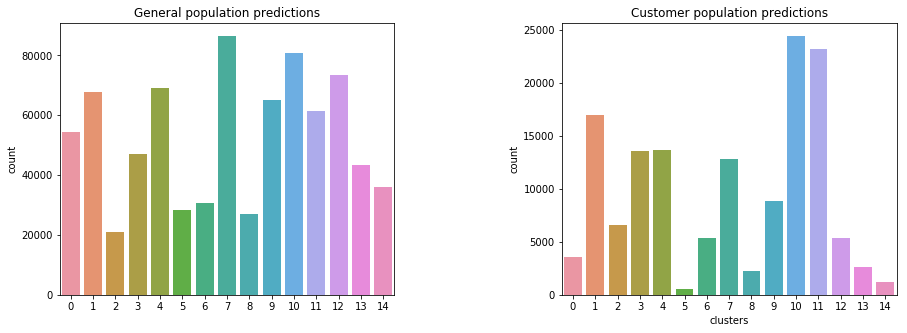

In [130]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig,axes=plt.subplots(ncols=2,figsize=(15,5))
#plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.5)

ax=sns.countplot(general_predictions,ax=axes[0]).set_title('General population predictions')
plt.xlabel('clusters')
ax=sns.countplot(customer_predictions,ax=axes[1]).set_title("Customer population predictions")
plt.xlabel("clusters")
plt.show();

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


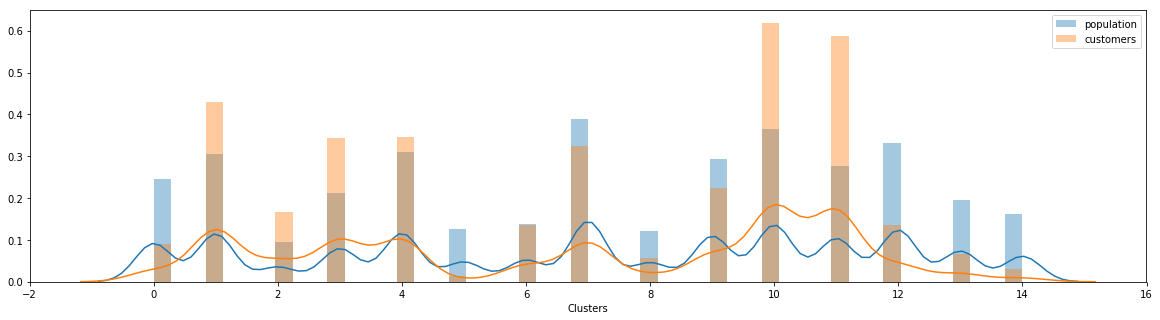

In [131]:
fig, axes = plt.subplots(figsize=(20,5))
sns.distplot(general_predictions, label='population',ax=axes)
sns.distplot(customer_predictions, label='customers',ax=axes)
plt.xlabel('Clusters')
plt.legend()
plt.show()

In [132]:
general_pop=[]
customer_pop=[]

for i in range(1,16):
    general_pop.append((general_predictions==i).sum()/len(general_predictions)*100)
    customer_pop.append((customer_predictions==i).sum()/len(customer_predictions)*100)


In [133]:
comp=pd.DataFrame({'Cluster':list(range(1,16)),'General':general_pop,'Customer':customer_pop})
comp

,Cluster,General,Customer
0,1,8.561039,12.029979
1,2,2.646516,4.688498
2,3,5.955039,9.590626
3,4,8.703664,9.690698
4,5,3.562219,0.407387
5,6,3.890636,3.777910
6,7,10.915868,9.101620
7,8,3.422497,1.596190
8,9,8.213059,6.259138
9,10,10.212461,17.323170


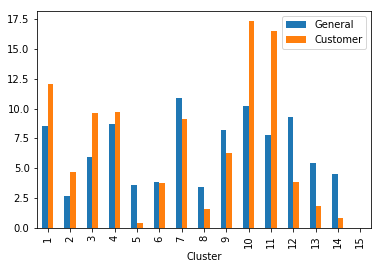

In [134]:
comp.plot.bar(x='Cluster',y=['General','Customer'])

In [135]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Cluster 4,Cluster 7 
reversed_pop=pd.DataFrame(scaler.inverse_transform(pca_new.inverse_transform(kmeans_new.cluster_centers_)),columns=customer_cleaned.columns,index=np.arange(1,16))
reversed_pop

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,GEBAEUDETYP_5.0
1,2.872358,0.802447,3.353838,2.426656,3.637177,2.087093,2.693546,3.188758,0.361306,2.136510,...,0.145314,0.116556,0.368111,-0.045344,0.691285,-0.160962,0.064228,0.092101,0.180768,0.599461
2,3.927504,1.296237,5.482157,0.743559,5.193009,1.048982,1.228168,1.664928,0.831238,1.842505,...,0.073913,-0.015778,0.124697,0.063100,0.799605,0.254657,0.003295,-0.006404,0.006510,-0.334710
3,3.016283,1.365655,3.464919,2.133917,4.098743,2.394032,2.504169,2.937514,0.444288,2.076987,...,0.114824,0.047060,0.231351,-0.001134,0.771924,0.071298,0.045661,0.040441,0.080177,0.002677
4,2.851970,0.809298,4.060579,2.195824,3.768133,2.253090,2.828564,2.201513,0.553603,2.016186,...,0.068024,0.000702,0.157332,0.051050,0.800557,0.233945,0.010430,-0.005362,0.006892,-0.309598
5,4.036294,1.756697,3.874963,0.916940,5.127686,1.127073,1.140992,3.917626,0.296810,1.787593,...,0.171998,0.092867,0.292195,-0.046384,0.699077,-0.149102,0.085140,0.100497,0.171146,0.422055
6,3.431398,1.279347,5.178563,1.415530,4.410319,1.763242,2.123514,0.980618,0.772745,1.992330,...,0.064236,-0.006515,0.167007,0.042280,0.938721,0.232613,0.004890,-0.006430,0.007032,-0.340689
7,3.080705,1.278449,4.847744,1.902248,3.624628,2.168264,2.738901,1.164676,0.816873,1.903668,...,0.086203,0.017282,0.189212,0.057087,0.762860,0.247074,0.012263,-0.002221,0.005496,-0.352020
8,3.920851,1.262307,5.337049,0.822163,5.041201,1.074272,1.397861,1.799374,0.674494,1.932230,...,0.075514,-0.000140,0.166369,0.053366,0.802961,0.249394,0.001984,-0.007146,0.006050,-0.356010
9,3.129285,1.509314,3.814710,1.899124,4.159333,2.293289,2.317101,2.589488,0.461900,2.025677,...,0.098706,0.035764,0.219395,0.019943,0.801212,0.108053,0.030651,0.033182,0.070349,-0.093846
10,2.836310,1.755539,3.329182,2.265335,3.822984,2.768505,2.871766,2.975106,0.426719,2.034546,...,0.064743,0.001824,0.150162,0.061515,0.797665,0.253632,0.000195,-0.007734,0.006754,-0.333749


In [142]:
targets=reversed_pop.loc[[1,3,10,11],:]
targets

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,GEBAEUDETYP_5.0
1,2.872358,0.802447,3.353838,2.426656,3.637177,2.087093,2.693546,3.188758,0.361306,2.136510,...,0.145314,0.116556,0.368111,-0.045344,0.691285,-0.160962,0.064228,0.092101,0.180768,0.599461
3,3.016283,1.365655,3.464919,2.133917,4.098743,2.394032,2.504169,2.937514,0.444288,2.076987,...,0.114824,0.047060,0.231351,-0.001134,0.771924,0.071298,0.045661,0.040441,0.080177,0.002677
10,2.836310,1.755539,3.329182,2.265335,3.822984,2.768505,2.871766,2.975106,0.426719,2.034546,...,0.064743,0.001824,0.150162,0.061515,0.797665,0.253632,0.000195,-0.007734,0.006754,-0.333749
11,3.820754,0.880370,4.424656,0.965909,5.072754,0.704064,1.175519,3.246899,0.348228,2.133097,...,0.160444,0.098814,0.316709,-0.044231,0.696999,-0.134528,0.080174,0.088895,0.154641,0.471730


In [143]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

non_targets=reversed_pop.loc[[5,12,13,14],:]
non_targets

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,GEBAEUDETYP_5.0
5,4.036294,1.756697,3.874963,0.916940,5.127686,1.127073,1.140992,3.917626,0.296810,1.787593,...,0.171998,0.092867,0.292195,-0.046384,0.699077,-0.149102,0.085140,0.100497,0.171146,0.422055
12,3.931918,1.464164,4.299456,0.833635,5.196805,1.238316,1.208471,3.474419,0.352928,1.885840,...,0.055189,0.008065,0.154424,0.067150,0.732736,0.253763,0.004701,-0.002913,0.004941,-0.333388
13,2.801564,1.766481,2.834071,2.381033,3.781479,2.515459,2.674848,3.756935,0.279989,1.954081,...,0.157585,0.111786,0.326137,-0.043433,0.677041,-0.160468,0.075411,0.089347,0.167810,0.591651
14,3.896189,1.251092,5.444786,0.784954,5.082605,0.985428,1.369958,1.758994,0.800400,1.922061,...,0.077965,-0.006668,0.142629,0.056787,0.803535,0.242956,0.005951,-0.003241,0.008721,-0.351005


In [144]:
targets.loc[:,['LP_STATUS_GROB_1.0','PLZ8_ANTG3','KBA05_ANTG1','MOBI_REGIO','ALTERSKATEGORIE_GROB','Decade','SEMIO_VERT','ANREDE_KZ']]

,LP_STATUS_GROB_1.0,PLZ8_ANTG3,KBA05_ANTG1,MOBI_REGIO,ALTERSKATEGORIE_GROB,Decade,SEMIO_VERT,ANREDE_KZ
1,0.451595,2.176144,1.075067,2.462694,2.872358,55.031714,6.794329,0.802447
3,0.191166,1.485232,1.940996,3.446234,3.016283,57.317062,4.987507,1.365655
10,0.095388,0.910019,2.660680,4.130665,2.836310,57.166179,3.614927,1.755539
11,0.326452,2.088952,1.148938,2.586504,3.820754,54.805814,6.586448,0.880370


In [145]:
non_targets.loc[:,['LP_STATUS_GROB_1.0','PLZ8_ANTG3','KBA05_ANTG1','MOBI_REGIO','ALTERSKATEGORIE_GROB','Decade','SEMIO_VERT','ANREDE_KZ']]

,LP_STATUS_GROB_1.0,PLZ8_ANTG3,KBA05_ANTG1,MOBI_REGIO,ALTERSKATEGORIE_GROB,Decade,SEMIO_VERT,ANREDE_KZ
5,0.383956,2.130361,1.080832,2.481928,4.036294,53.668191,3.704184,1.756697
12,0.027957,0.986058,2.206686,3.736929,3.931918,54.905426,4.846355,1.464164
13,0.513153,2.164786,1.108068,2.508257,2.801564,53.403123,3.379061,1.766481
14,-0.119472,0.833496,3.350309,4.705628,3.896189,66.721382,5.664047,1.251092


### Discussion 3.3: Compare Customer Data to Demographics Data

We can see from the plots that there is a good match for some clusters between general population and customers.However for some clusters there significantly larger customers than population. These are custer 4,7 and followed by 14,
from first 3 principal component we compare the targets(customers>general) with non-targets(customers<general)

We see that

LP_STATUS_GROB_1:Social status is comparitively higher for non targets than targets

PLZ8_ANTG3:Number of 6-10 family houses in the PLZ8 region higher for non targets

Decade: seems to be higher for targets

ANREDE_KZ:Gender slightly higher for targets


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.